# Applying PyMC3 to Marketing Conversion data
One good use of Probabilistic Programming is trying to say something about our conversions.
We'll generate some fake data and do a simple 'transaction_observed' model since that's the kind of thing we would try to model with such data sets in the 'real world'. 

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('bmh')
colors = ['#348ABD', '#A60628', '#7A68A6', '#467821', '#D55E00', 
          '#CC79A7', '#56B4E9', '#009E73', '#F0E442', '#0072B2']

## We'll generate some example marketing data
* Afterwrds we'll generate a simple model with a prior - exponetial (not necessarily a good prior)
* Some simple data
* We'll try to infer a model for the observed number of transactions.
* Afterwards we'll apply Posterior Predictive Checks to this posterior. 

In [3]:
import pandas as pd

channels = {'A': [2292.04, 9],
           'B': [1276.85, 2],
           'C': [139.59, 3],
           'D': [954.98, 5],
           'E': [8000.98, 12],
            'F': [2678.04, 6]
           }


df = pd.DataFrame(channels)
df.values[1]

array([  9.,   2.,   3.,   5.,  12.,   6.])

In [4]:
import pymc3 as pm
import matplotlib.pyplot as plt
import numpy as np
import sys
import theano.tensor as tt
import seaborn as sns

spend_obs = df.values[0]
transactions_obs = df.values[1]

model = pm.Model()
with pm.Model() as model:
        # We'll use Exponential as our prior
        c = pm.Exponential('Prior', 1/50.)
    
        
        e = pm.Deterministic('spends_observations', spend_obs/ c)  
        # The observed number of transactions is a Poisson with mu set to the expectations
        a = pm.Poisson('transactions_observed', mu=e, observed=transactions_obs)

/Users/peadarcoyle/anaconda/envs/sea/lib/python3.4/site-packages/matplotlib/__init__.py:872: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


 [-----------------100%-----------------] 20000 of 20000 complete in 3.9 sec

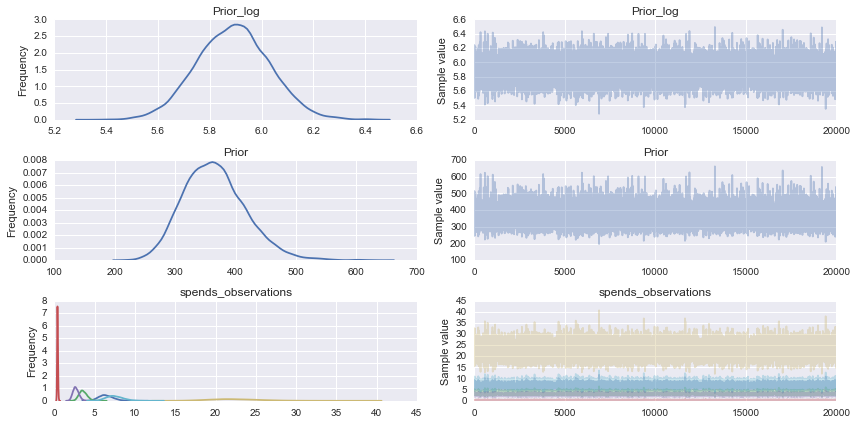

In [5]:
with model: 
    start = pm.find_MAP()
    step = pm.NUTS( scaling=start, gamma=.55)
    trace = pm.sample(20000, step, start=start, progressbar=True)

    pm.traceplot(trace)

In [21]:
spends = trace.get_values('spends_observations')
Prior = trace.get_values('Prior')

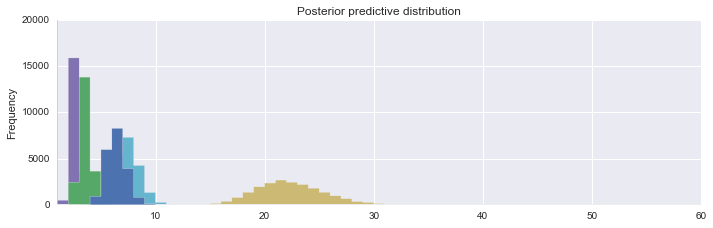

In [23]:
x_lim = 60
burnin = 50000



fig = plt.figure(figsize=(10,6))
fig.add_subplot(211)

_ = plt.hist(spends, range=[0, x_lim], bins=x_lim, histtype='stepfilled')   
_ = plt.xlim(1, x_lim)
_ = plt.ylabel('Frequency')
_ = plt.title('Posterior predictive distribution')


plt.tight_layout()

# Posterior Predictive Checks
PPCs are a great way to validate a model. The idea is to generate data sets from the model using parameter settings from draws from the posterior.

In [29]:

# Simply running PPC will use the updated values and do prediction
ppc = pm.sample_ppc(trace, model=model, samples=500)



One common way to visualize is to look if the model can reproduce the patterns observed in the real data. For example, how close are the inferred means to the actual sample mean:

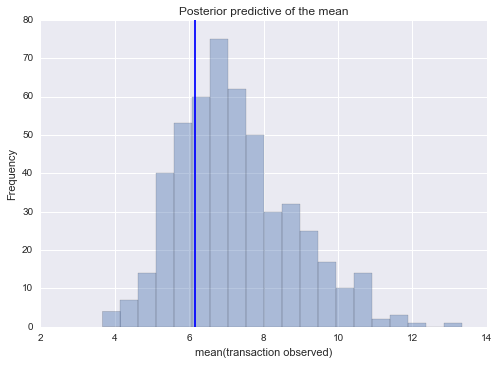

In [30]:
ax = plt.subplot()
sns.distplot([n.mean() for n in ppc['transactions_observed']], 
             kde=False, ax=ax)
ax.axvline(transactions_obs.mean())
ax.set(title='Posterior predictive of the mean', xlabel='mean(transaction observed)', ylabel='Frequency');
